In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [4]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)  # Loading image
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resizing for consistency
            images.append(img)
            labels.append(label)
    
    return images, labels

# Loading both categories
with_mask_images, with_mask_labels = load_images_from_folder("./dataset/with_mask", 1)
without_mask_images, without_mask_labels = load_images_from_folder("./dataset/without_mask", 0)

# Combining datasets
X_images = with_mask_images + without_mask_images
y_labels = with_mask_labels + without_mask_labels


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


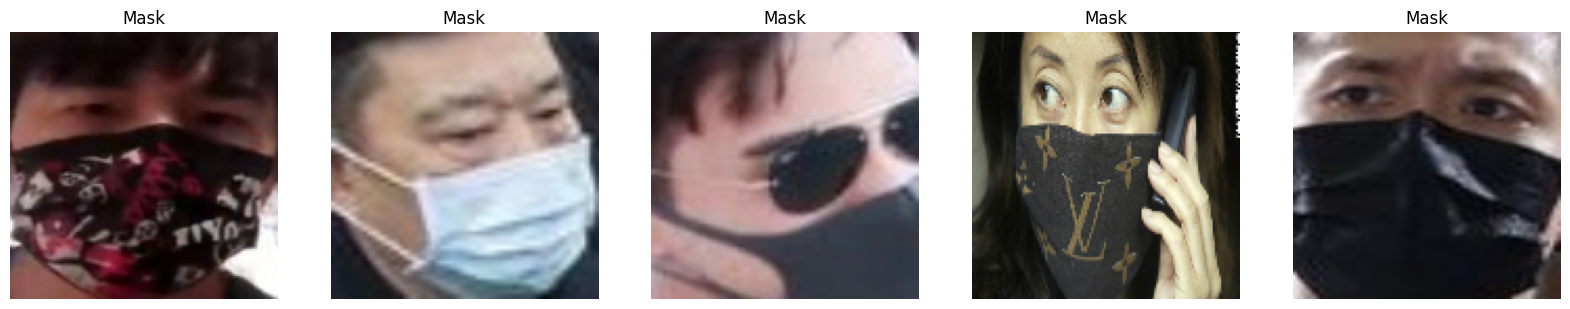

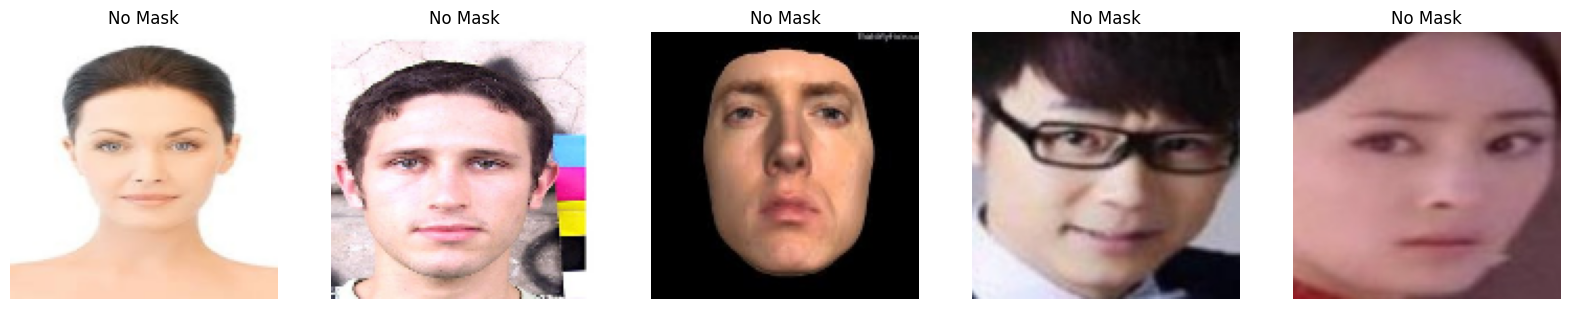

Number of images with mask:  2165
Number of images without mask:  1930
Total number of images:  4095


In [8]:
#Dataset Analysis

# Plotting the first 5 images with and without mask
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(cv2.cvtColor(with_mask_images[i], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')
    ax[i].set_title("Mask")
plt.show()
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(cv2.cvtColor(without_mask_images[i], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')
    ax[i].set_title("No Mask")
plt.show()

# Size of dataset
print("Number of images with mask: ", len(with_mask_images))
print("Number of images without mask: ", len(without_mask_images))
print("Total number of images: ", len(X_images))



In [3]:
def extract_hog_features(image):
    gray = rgb2gray(image) 
    features, _ = hog(gray, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualize=True)
    return features

In [4]:
def extract_color_histogram(image, bins=32):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Converting to HSV
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

In [5]:
def extract_lbp_features(image, radius=2, n_points=16):  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return hist


In [6]:
def extract_canny_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Applying Canny edge detection
    return edges.flatten()  # Flattening the edge image into a feature vector


In [7]:
def extract_sift_features(image, num_keypoints=50):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        return np.zeros(num_keypoints * 128)

    # Sort keypoints and descriptors by response (descending)
    if len(keypoints) > 0:
        kp_desc = list(zip(keypoints, descriptors))
        kp_desc.sort(key=lambda x: x[0].response, reverse=True)
        sorted_descriptors = np.array([desc for _, desc in kp_desc])
    else:
        sorted_descriptors = descriptors

    # Select top N descriptors or pad if needed
    if len(sorted_descriptors) < num_keypoints:
        pad_size = num_keypoints - len(sorted_descriptors)
        padded = np.vstack([sorted_descriptors, np.zeros((pad_size, 128))])
        selected = padded
    else:
        selected = sorted_descriptors[:num_keypoints]

    sift_vector = selected.flatten()
    return sift_vector

In [8]:
def extract_features(image):
    hog_feat = extract_hog_features(image)
    lbp_feat = extract_lbp_features(image)
    canny_feat = extract_canny_features(image)
    sift_feat = extract_sift_features(image)
    colour_hist = extract_color_histogram(image)

    # Concatenating all features into one feature vector
    feature_vector = np.hstack((hog_feat, lbp_feat, canny_feat, sift_feat, colour_hist))
    return feature_vector

# Extracting features from all images
X_features = np.array([extract_features(img) for img in X_images])
y = np.array(y_labels)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)

print("SVM Accuracy:", svm_acc)
print(classification_report(y_test, svm_preds))

SVM Accuracy: 0.9304029304029304
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       366
           1       0.93      0.94      0.94       453

    accuracy                           0.93       819
   macro avg       0.93      0.93      0.93       819
weighted avg       0.93      0.93      0.93       819



In [11]:
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation="relu")
mlp_model.fit(X_train, y_train)

mlp_preds = mlp_model.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)

print("MLP Accuracy:", mlp_acc)
print(classification_report(y_test, mlp_preds))


MLP Accuracy: 0.9377289377289377
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       366
           1       0.95      0.94      0.94       453

    accuracy                           0.94       819
   macro avg       0.94      0.94      0.94       819
weighted avg       0.94      0.94      0.94       819



In [12]:
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"MLP Accuracy: {mlp_acc:.4f}")


SVM Accuracy: 0.9304
MLP Accuracy: 0.9377


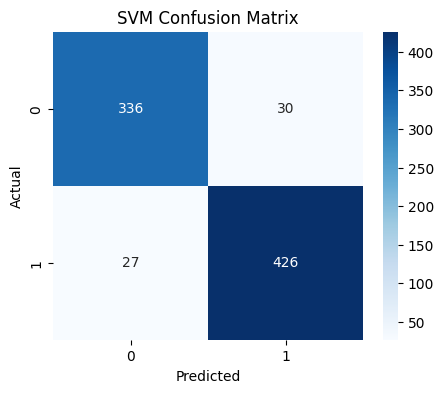

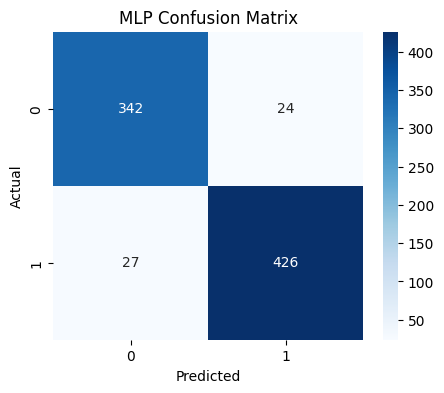

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, svm_preds, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, mlp_preds, "MLP Confusion Matrix")
